# Basic approach for measurement uncertainty evalaution
First name: principle modelling (PM)

## Contribution to CIE2023 in Ljubljana

# Modelling

## wavelength scale
$\mathbf{\lambda}^\mathrm{r}=k_{\mathrm{\lambda,m-c}}\bullet\left(\mathbf{\lambda}+\lambda_{\mathrm{a-c}}+\mathbf{\lambda}_{\mathrm{a-uc}}+\mathbf{\lambda}_{\mathrm{a-b}}\right)$

### new version for LRT
$\mathbf{\lambda}^\mathrm{r}=f_\lambda^{-1}\left(k_{\mathrm{\lambda,m-c}}\bullet f_\lambda\left(\mathbf{\lambda}\right)\right)+\lambda_{\mathrm{a-c}}+\mathbf{\lambda}_{\mathrm{a-uc}}+\mathbf{\lambda}_{\mathrm{a-b}}$

## value scale
$\mathbf{S}^\mathrm{r}=\mathbf{S}\bullet \mathbf{k}_{\mathrm{S,m-f}}\bullet \left(1+S_{\mathrm{a-c}}+\mathbf{S}_{\mathrm{a-uc}}+\mathbf{S}_{\mathrm{a-b}}\right)$

## new version for LRT
$\mathbf{S}^\mathrm{r}=\mathbf{k}_{\mathrm{S,m-f}}\bullet \mathbf{S} +S_{\mathrm{a-c}}+\mathbf{S}_{\mathrm{a-uc}}+\mathbf{S}_{\mathrm{a-b}}$

Remark:
The different modelling of the scales it due to the usual way of using the uncertainty contributions only.
In the wavelength scale we use absolute uncertainties every time, whereas in the value scale we use relative once. Therefore, the modelling is made a little bit different.

In [1]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.tools import plotHistScales, plotHistGauss, plot_2D, seaborn_plot_result_gen
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar, load_from_csv, load_from_excel, StatDataVector
from empir19nrm02 import _SPD, _RES
import pandas as pd
import matplotlib.ticker as ticker
import luxpy as lx
import time

out_dir = 'MCSim_PM'

# comma or point as decimal separator (True--> CIE, False-->LRT)
version_LRT = True
use_comma = False
if use_comma:
    dec_sep = ','
else:
    dec_sep = '.'

NumberTrials = 20000
# Number of base functions (as a hack with pos/neg number of base functions to select the type...)
# >0 use sin/cos base functions
# <0 use chebyshev base functions
N_Fourier = 'c 7'
N_Fourier1 = 'f 7'
N_Fourier2 = 'f 7 s'
N_Fourier3 = 'f 7 1f'
maxOutElements = 5
lambda0 = 555

# Number of base functions
highRes = 1
if highRes == 0:
    wl = lx.getwlr([360,830,5])
    len_wl = len(wl)
    elements2Run = [-1, 0,1,2,3,4,5,6,7,8,9,10,20,30,int(len_wl/2)]
else:
    wl = lx.getwlr([360,830,1])
    len_wl = len(wl)
    # new elements2Run (see logscale.xlsx for a linear distribution of values in a log scale format)
    elements2Run = [-1, 0,1,2,3,4,5,6,7,8,9,10,11,12,15,19,24,30,38,48,60,75,95,119,149,187,235]
print( elements2Run)

# wavelength range for the normalization
lambdaMin = wl[0]
lambdaMax = wl[-1]

# distribution temperature for the blackBody
T0 = 3077

# peak_wavelength for the LED modelling
led_peak = 555
led_bandwidth = 20

import os
print( 'CWD:', os.getcwd())

marker = ['-', '--', '-.',':', '.', 'o', '-', '--','-.',':','.']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r', 'g', 'b', 'c']

if use_comma:
    #Locale settings
    import locale
    # Set to German locale to get comma decimal separater
    locale.setlocale(locale.LC_NUMERIC, "de_DE")

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 19, 24, 30, 38, 48, 60, 75, 95, 119, 149, 187, 235]
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
# Benutzerdefinierter Stil definieren
plot_style = {
    'axes.spines.top': True,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.linewidth': 1,
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.major.size': 2,
    'ytick.major.size': 2,
    'axes.grid': False,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.bottom': True,
    'ytick.left': True,
}

# Stil aktivieren
pyplot.style.use(plot_style)
if use_comma:
    # Tell matplotlib to use the locale we set above
    pyplot.rcParams['axes.formatter.use_locale'] = True

In [3]:
def custom_decimal(value_str):
    # Split the string into integer and decimal parts
    integer_part, decimal_part = value_str.split('.')
    # Add spaces after every third character in the integer part
    decimal_part_formatted = " ".join([decimal_part[i:i+3] for i in range(0, len(decimal_part), 3)])
    # Join the formatted integer part with the decimal part and return the result
    formatted_value = integer_part + dec_sep + decimal_part_formatted

    return formatted_value

def custom_color(x,pos):
    value_str = f"{x:,.{4}f}"
    return custom_decimal(value_str)
def custom_color1(x,pos):
    value_str = f"{x:,.{5}f}"
    return custom_decimal(value_str)

def custom_formatter(x, pos):
    # Convert the float to a string
    value_str = f"{x:,.{0}f}"

    # Split the string into integer and decimal parts
    integer_part, decimal_part = value_str.split('.')

    # Add spaces after every third character in the integer part
    decimal_part_formatted = " ".join([decimal_part[i:i+3] for i in range(0, len(decimal_part), 3)])
    # Add spaces after every third character in the integer part
    #integer_part_formatted = integer_part.replace(",", " ")
    integer_part_formatted = integer_part
    #integer_part_formatted = " ".join([integer_part[i:i+3] for i in range(0, len(integer_part), 3)])

    # Join the formatted integer part with the decimal part and return the result
    formatted_value = integer_part_formatted + dec_sep + decimal_part_formatted

    return formatted_value

### Draw some reference curves for the article

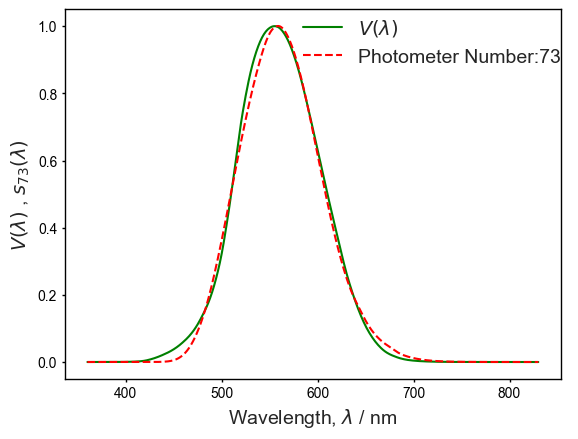

In [4]:
x_label = 'Wavelength, $\lambda}$ / nm'
y_label = 'Signal $S$ / A.U.'

selected_Detector = 73
_detectors=_RES['VLDetectors']['S']['data'].copy()

_detectors_i = lx.cie_interp(_detectors, wl_new=wl, kind='S')
s_target = _detectors_i[1]
currentDetector = _detectors_i[selected_Detector]

fig0, ax0 = pyplot.subplots()

ax0.plot(wl, _detectors_i[1],'g-', label=strd['VLambda'])
ax0.plot(wl, _detectors_i[selected_Detector],'r--', label=r'Photometer Number:' + str(selected_Detector))
ax0.set_xlabel(x_label,fontsize=label_font_size)
ax0.set_ylabel(strd['VLambda'] + r' , $s_{' + str(selected_Detector) + '}(\lambda)$',fontsize=label_font_size)
fig0.legend(bbox_to_anchor=(0.47, 0.6, 0.4, 0.3), loc='upper left', frameon=False,fontsize=label_font_size)

save_fig(out_dir, filename='SampleDetectorSPD')


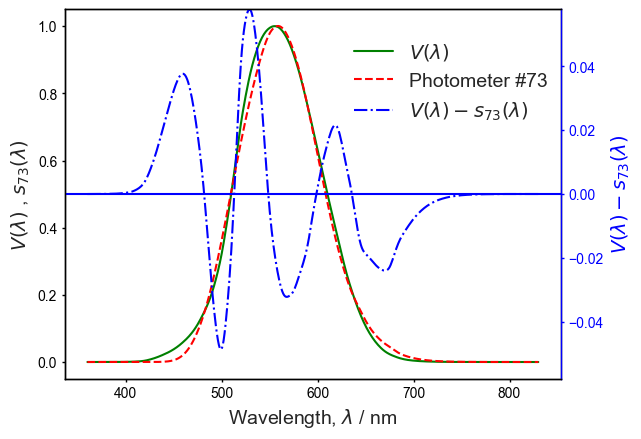

In [5]:
strNumberDetector = str(selected_Detector)

fig0, ax0 = pyplot.subplots()
strNumber = str(selected_Detector)
ax0.plot(wl, s_target,'g-', label=strd['VLambda'])
ax0.plot(wl, _detectors_i[selected_Detector],'r--', label=r'Photometer #' + strNumber)
ax0.set_ylabel(strd['VLambda'] + r' , $s_{' + strNumber + '}(\lambda)'+ '' +'$',fontsize=label_font_size)
ax0.set_xlabel(x_label,fontsize=label_font_size)


strDiff = '$V(\lambda)-s_{' + strNumberDetector + '}(\lambda)$'
ax1 = ax0.twinx()

f = np.sum(s_target)/np.sum(_detectors_i[selected_Detector])
diff_detector = s_target-f*_detectors_i[selected_Detector]
ax1.plot(wl, diff_detector, 'b-.', label=strDiff)
ax1.set_ylabel( strDiff,fontsize=label_font_size)

ax1.set_ylim((-np.max(np.abs(diff_detector)), np.max(np.abs(diff_detector))))
ax1.axhline(0, color = 'blue')


[lines, labels]=label_management( fig0, ax1, 'blue')
fig0.legend(lines, labels, bbox_to_anchor=(0.55, 0.55, 0.4, 0.3), loc='upper left',frameon=False,fontsize=label_font_size)


save_fig(out_dir, filename='SampleDetectorAbsDiff')

In [6]:
def plotMCResult( wl, mcVarData:StatDataVector, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g:'
    else:
        if diagnumber == 1:
            color1 = 'r-'
            color2 = 'g:'
        else:
            color1 = 'r--'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVarData.v_mean/np.max(mcVarData.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl,mcVarData.v_std / mcVarData.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(x_label,fontsize=label_font_size)
    ax1.set_ylabel(y_label, color = 'red',fontsize=label_font_size)
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green',fontsize=label_font_size)
    if title:
        ax1.set_title(title)
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color))
    fig.legend(bbox_to_anchor=(.6,.6), loc="upper left", frameon=False, fontsize=label_font_size)
    return fig, ax1, ax2

FEL integral data: CCT: [[3.0777e+03]] K, Duv: [[2.0527e-04]]


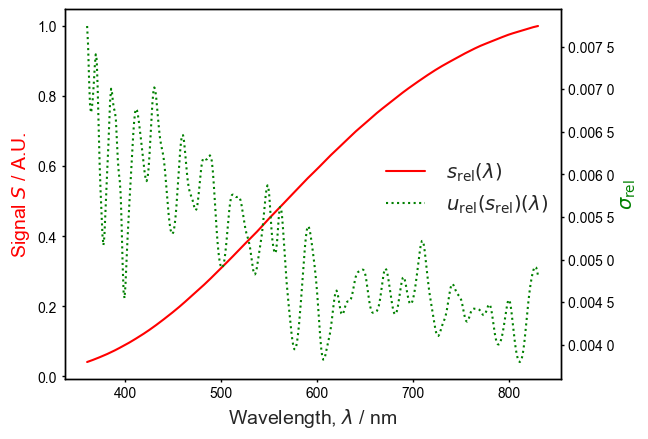

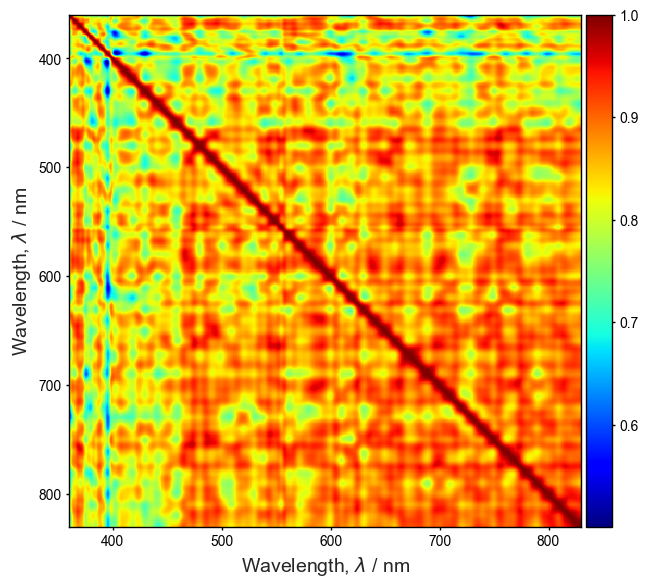

In [7]:
from empir19nrm02.spectral.spectral_data import _CORR_PATH
from glob import glob

file_list = glob(_CORR_PATH + "PTBResFEL-1000W-Lamp-1.csv", recursive = False)
for file in file_list:
    if 'xls' in file:
        wlFEL, mcVectorVarFEL = load_from_excel(filename= file, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
    else:
        wlFEL, mcVectorVarFEL = load_from_csv(filename= file)
        XYZ_FEL = lx.spd_to_xyz(np.vstack((wlFEL, mcVectorVarFEL.setData.v_mean)), relative=False)
        CCT_FEL, duv_FEL = lx.xyz_to_cct(XYZ_FEL, out = 'cct,duv')
        print( f"FEL integral data: CCT: {CCT_FEL} K, Duv: {duv_FEL}")
    mcVectorVarFEL.interpolate(wl, wlFEL, trials=NumberTrials)
    file_base = os.path.basename(file)
    fig, ax1, ax2 = plotMCResult(wl, mcVectorVarFEL.setData)
    save_fig(out_dir, filename='FEL')
    #fig.legend(bbox_to_anchor=(1,1), loc="upper left")
    plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wl, '', x_label=x_label, y_label=x_label)
    save_fig(out_dir, filename='CorrFEL')

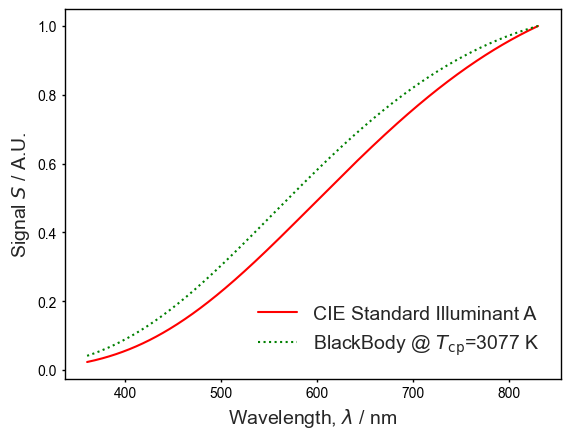

In [8]:
spectra=_SPD['PHOTOLED']['S']['data'].copy()

fig0, ax0 = pyplot.subplots()
spectra_i = lx.cie_interp(spectra, wl_new=wl, kind='S')
bb_T0 = lx.blackbody(T0, wl, relative=False)
ax0.plot(wl, spectra_i[1]/np.max(spectra_i[1]), 'r-', label=r'CIE Standard Illuminant A')
ax0.plot(wl, bb_T0[1]/np.max(bb_T0[1]), 'g:', label=r'BlackBody @ $T_{\mathrm{cp}}$=' + str(T0) + ' K')
#ax0.plot(wl,mcVectorVarFEL.setData.v_mean/np.max(mcVectorVarFEL.setData.v_mean), 'bx', label=r'FEL')
ax0.set_ylabel( y_label,fontsize=label_font_size)
ax0.set_xlabel( x_label,fontsize=label_font_size)

fig0.legend(bbox_to_anchor=(0.4, 0.05, 0.4, 0.25), loc='upper left', frameon=False,fontsize=label_font_size)

save_fig(out_dir, filename='SampleSD')

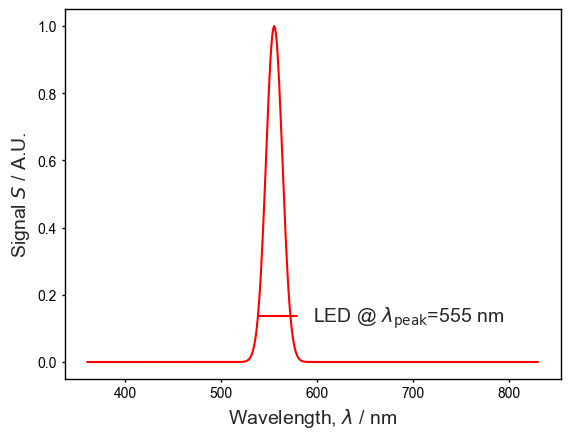

In [9]:
fig0, ax0 = pyplot.subplots()
led = lx.toolboxes.spdbuild.gaussian_spd( \
        peakwl=led_peak, fwhm=led_bandwidth, wl=wl, with_wl=False)

ax0.plot(wl, led[0]/np.max(led[0]), 'r-', label=r'LED @ $\lambda_{\mathrm{peak}}$=' + str(led_peak) + ' nm')
ax0.set_ylabel( y_label,fontsize=label_font_size)
ax0.set_xlabel( x_label,fontsize=label_font_size)

fig0.legend(bbox_to_anchor=(0.4, 0.05, 0.4, 0.25), loc='upper left', frameon=False,fontsize=label_font_size)

save_fig(out_dir, filename='SampleLED')

# Show the basis function approach

0.0
1.0
1.0000000000000002
1.0


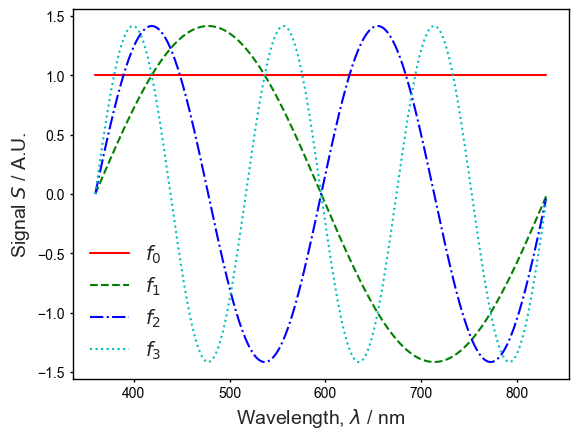

0.0
1.0
1.0
0.9999999999999999


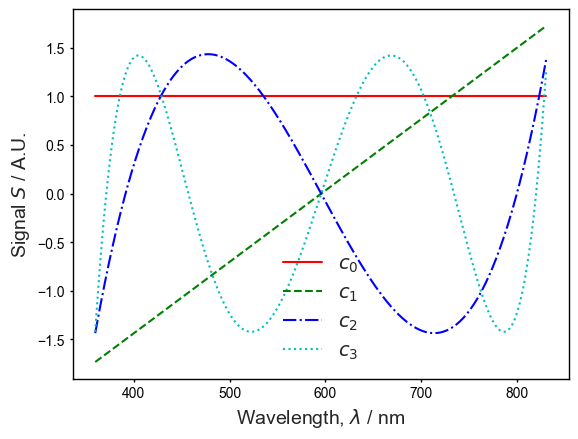

0.0
0.4170752386756492
0.9627957309130653
0.9956732707221081


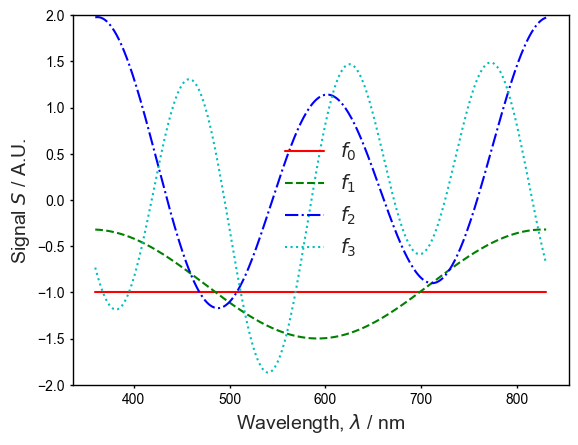

0.0
0.5127933089045105
1.1217759636529792
1.1618085075414093


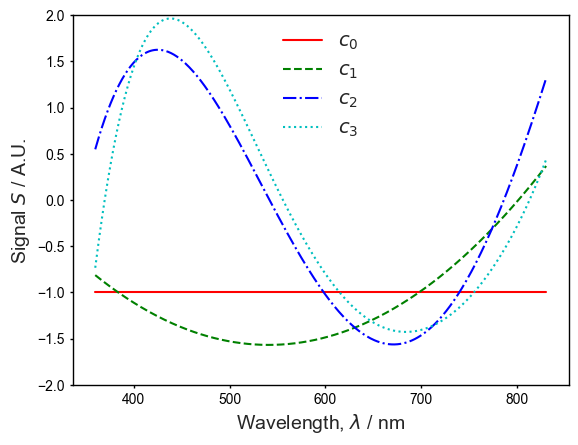

In [10]:
from empir19nrm02.MC import  generate_base_functions

base_function_steps = len(wl)

def plot_base_functions( mode, mode2):
    for number_base in range(4):
        baseFunctions = generate_base_functions(mode + ' '  + str(number_base)+ ' ' + mode2, base_function_steps, 1)
        if 'f' in mode:
            pyplot.plot( wl, baseFunctions, mColor[number_base]+marker[number_base], label=r'$f_{' + str(number_base) + '}$')
        else:
            pyplot.plot( wl, baseFunctions, mColor[number_base]+marker[number_base], label=r'$c_{' + str(number_base) + '}$')

        print( np.std(baseFunctions))

    pyplot.xlabel(x_label, size=label_font_size)
    pyplot.ylabel(y_label, size=label_font_size)
    pyplot.legend(frameon=False,fontsize=label_font_size)

plot_base_functions('f', 'o s ng')
save_fig(out_dir, 'base_functions_f')
plot_base_functions('c', 'o s ng')
save_fig(out_dir, 'base_functions_c')

plot_base_functions('f', 'o')
pyplot.ylim([-2,2])
save_fig(out_dir, 'base_functions_fr')
plot_base_functions('c', 'o')
pyplot.ylim([-2,2])
save_fig(out_dir, 'base_functions_cr')

# Make some very first MCS

In [11]:
# define some input data (as MCVar to make an analysis after the run)

# Change of the BB Temperature
mcT = MCVar(name=NameUnit('T', 'K'), distribution=DistributionParam(mean=T0,stddev=1., distribution='normal'))

mcLED = MCVar(name=NameUnit('led_peak', 'nm'), distribution=DistributionParam(mean=led_peak,stddev=1., distribution='normal'))

# wavelength

# Correlated noise (once for every trial)
mcLambda_a_c = MCVar(name=NameUnit('$\lambda_\mathrm{a-c}$', 'nm'), distribution=DistributionParam(mean=0.,stddev=1., distribution='normal'))

# uncorrelated noise (once for every trial and every wavelength position)
mcLambda_a_uc = MCVectorVar(name=NameUnit('$\lambda_\mathrm{a-uc}$', 'nm'), elements=len(wl))
mcLambda_a_uc.set_vector_param( np.zeros(len(wl)), np.ones(len(wl)))

# base function noise (one selected setting only)
mcLambda_a_f = MCVectorVar(name=NameUnit('$\lambda_\mathrm{a-b}$', 'nm'), elements=len(wl), noise_list={ 'f_add': DistributionParam(mean = 0, stddev = 1, distribution = 'normal', add_params = N_Fourier)})
mcLambda_a_f.set_vector_param( np.zeros(len(wl)), np.ones(len(wl)))

# correlated factor for the wavelength calibration 
# base function noise (one selected setting only)
mcLambda_m_f = MCVectorVar(name=NameUnit('$\lambda_\mathrm{m-b}$', 'nm'), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcLambda_m_f.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))

# Signal
mcS_a_c = MCVar(name=NameUnit('$S_\mathrm{a-c}$', ''), distribution=DistributionParam(mean=0.,stddev=0.01, distribution='normal'))

mcS_a_uc = MCVectorVar(name=NameUnit('$S_\mathrm{a-uc}$', ''), elements=len(wl))
mcS_a_uc.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mcS_a_f = MCVectorVar(name=NameUnit('$S_\mathrm{a-b}$', ''), elements=len(wl), noise_list={ 'f_add': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcS_a_f.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_f = MCVectorVar(name=NameUnit('$k_\mathrm{S,m-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcS_m_f.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_f1 = MCVectorVar(name=NameUnit('$k_\mathrm{S,m-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier1)})
mcS_m_f1.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_f2 = MCVectorVar(name=NameUnit('$k_\mathrm{S,m-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier2)})
mcS_m_f2.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_f3 = MCVectorVar(name=NameUnit('$k_\mathrm{S,m-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier3)})
mcS_m_f3.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))

# define some output data (as MCVar to make an analysis after the run)
mcYxy = MCVectorVar(name=NameUnit(['L','x','y'], ['','','']), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))
mclpeak = MCVar(name=NameUnit('lpeak', 'nm'))
mcDuv = MCVar(name=NameUnit('Duv', ''))
mcSMCF = MCVar(name=NameUnit('F', ''))
mcSpectrum = MCVectorVar(name=NameUnit('L', ''), elements=len(wl))

# define some basic data needed inside the MCS
kBB = 1./(lx.spd_to_xyz(lx.blackbody(T0, wl, relative=False))[0][1])
kBBMax = 1./(lx.blackbody(T0, wl, relative=False)[1].max())

# helpwise the delta lambda values for the integration
dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

def runSimpleMC( input, output, NumberTrials, model_function):
    sim = MCSimulation(trials=NumberTrials)
    sim.set_input_var(input)
    sim.set_output_var(output)
    sim.generate()
    sim.calculate_model( model_function)
    return sim.output_var, sim.get_result_db()
def f_lambda(wl):
    return (wl-lambdaMin)/(lambdaMax-lambdaMin)  
def f_lambda_1(wls):
    return wls*(lambdaMax-lambdaMin)  + lambdaMin

# simple model calculating the photometric integrals
def model_L0( trial, T, Lambda_a_c, Lambda_a_uc, Lambda_a_f, Lambda_m_f, S_a_c, S_a_uc, S_a_f, S_m_f):
    #wl_in = (1. + Lambda_a_c + Lambda_a_uc + Lambda_a_f)
    if version_LRT:
        wl_mod = f_lambda_1(Lambda_m_f*f_lambda(wl))+ Lambda_a_c + Lambda_a_uc + Lambda_a_f
    else:
        wl_mod = Lambda_m_f*(wl + Lambda_a_c + Lambda_a_uc + Lambda_a_f)
    # using the manipulated wl-scale for calculation of the bb
    bb = lx.blackbody(T, wl_mod, relative=False)
    # reconstruct the nominal one
    bb_mod = bb.copy()
    bb_mod[0] = wl
    if version_LRT:
        bb_mod[1] *= kBBMax
        bb_mod[1] = bb_mod[1]*S_m_f + S_a_c + S_a_uc + S_a_f
    else:
        bb_mod[1] *= kBB
        bb_mod[1] = bb_mod[1]*S_m_f*(1. + S_a_c + S_a_uc + S_a_f)
    XYZ = lx.spd_to_xyz(bb_mod, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    #SMCF = (bb_mod[1] @ (s_target*dl).T) / (bb_mod[1] @ (currentDetector*dl).T)
    SMCF=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(bb_mod, np.vstack((wl, currentDetector)), S_C='A')[0]

    return [Yxy[0], CCT, SMCF, bb_mod[1]]

# simple model calculating the photometric integrals
def model_LED( trial, lPeak, Lambda_a_c, Lambda_a_uc, Lambda_a_f, Lambda_m_f, S_a_c, S_a_uc, S_a_f, S_m_f):
    if version_LRT:
        wl_mod = f_lambda_1(Lambda_m_f*f_lambda(wl))+Lambda_a_c + Lambda_a_uc + Lambda_a_f
    else:
        wl_mod = Lambda_m_f*(wl + Lambda_a_c + Lambda_a_uc + Lambda_a_f)

    # using the manipulated wl-scale for calculation of the LED
    led = lx.toolboxes.spdbuild.gaussian_spd( \
        peakwl=lPeak, fwhm=led_bandwidth, wl=wl_mod, with_wl=True)
    # reconstruct the nominal one
    led_mod = led.copy()
    led_mod[0] = wl
    led_mod[1] *= 1
    if version_LRT:
        led_mod[1] = led_mod[1]*S_m_f + S_a_c + S_a_uc + S_a_f
    else:
        led_mod[1] = led_mod[1]*S_m_f*(1. + S_a_c + S_a_uc + S_a_f)
    XYZ = lx.spd_to_xyz(led_mod, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    lPeakRes = lx.detect_peakwl(led_mod, verbosity=0)[0]['peaks']
    #SMCF = (bb_mod[1] @ (s_target*dl).T) / (bb_mod[1] @ (currentDetector*dl).T)
    SMCF=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(led_mod, np.vstack((wl, currentDetector)), S_C='A')[0]

    return [Yxy[0], lPeakRes, SMCF, led_mod[1]]

# simple model calculating the photometric integrals from a FEL Lamp
def model_FEL( trial, inFEL):
    specFEL = np.vstack((wl, inFEL))
    XYZ = lx.spd_to_xyz(specFEL, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    SMCF=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors(specFEL, np.vstack((wl, currentDetector)), S_C='A')[0]

    return [Yxy[0], CCT, SMCF, inFEL]

input = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f]
input_len = len(input)
output = [mcYxy, mcCCT, mcSMCF, mcSpectrum]

startMC = time.time()
mcResult, res_data = runSimpleMC(input, output, NumberTrials, model_L0)
endMC = time.time()

estTime = 4*len(elements2Run)*(endMC-startMC)
print(f"Estimated full running time for 4 times {len(elements2Run)} simulations: {estTime} s --> {estTime/3600} h")


res_data.to_csv(out_dir + '/table1.csv', sep=';', decimal=',')
res_data


Estimated full running time for 4 times 27 simulations: 13195.922109603882 s --> 3.6655339193344116 h


,Input,Unit,Mean,StdDev,Distr,L,u(L),x,u(x),y,u(y),CCT,u(CCT),F,u(F)
0,T,K,"3,077.00000000",1.00000000,normal,1.00001388,0.00267935,0.43155462,0.00006860,0.40215530,0.00002541,"3,077.00415838",1.00013846,1.00240357,0.00001001
0,$\lambda_\mathrm{a-c}$,nm,0.00000000,1.00000000,normal,0.99998843,0.00581532,0.43155727,0.00056267,0.40215574,0.00025627,"3,076.98303117",7.81020211,1.00240319,0.00007476
0,$\lambda_\mathrm{a-uc}$,nm,0.00000000,1.00000000,normal,0.99999750,0.00048293,0.43155327,0.00009931,0.40215332,0.00011635,"3,077.01188932",1.73126913,1.00240350,0.00002348
0,$\lambda_\mathrm{a-b}$,nm,0.00000000,1.00000000,normal c 7,0.99998205,0.00664740,0.43155431,0.00085071,0.40215344,0.00078149,"3,077.03663960",13.89130024,1.00240296,0.00010700
0,$\lambda_\mathrm{m-b}$,nm,0.00000000,0.01000000,normal c 7,0.99999530,0.01334964,0.43154001,0.00109249,0.40214378,0.00104235,"3,077.23288049",22.91211879,1.00240409,0.00015701
0,$S_\mathrm{a-c}$,,0.00000000,0.01000000,normal,0.99977807,0.02105260,0.43164483,0.00250556,0.40221846,0.00175642,"3,076.35052200",29.63291719,1.00239488,0.00027661
0,$S_\mathrm{a-uc}$,,0.00000000,0.01000000,normal,1.00000434,0.00174022,0.43155517,0.00040801,0.40215565,0.00049495,"3,077.00525514",6.42563333,1.00240373,0.00008846
0,$S_\mathrm{a-b}$,,0.00000000,0.01000000,normal c 7,0.99988055,0.02408784,0.43163723,0.00363455,0.40222354,0.00353678,"3,076.87446453",52.63608171,1.00239543,0.00041989
0,"$k_\mathrm{S,m-b}$",,0.00000000,0.01000000,normal c 7,0.99995026,0.01133871,0.43156144,0.00097566,0.40214825,0.00088293,"3,076.88028824",20.01199532,1.00240470,0.00014913
0,All,,0.00000000,0.00000000,,0.99958864,0.03769539,0.43172141,0.00482926,0.40226590,0.00431469,"3,076.37863484",70.10166578,1.00238753,0.00057462


In [12]:
inputFEL = [mcVectorVarFEL]
input_len = len(input)
output = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
mcResultFEL, res_dataFEL = runSimpleMC(inputFEL, output, NumberTrials, model_FEL)

res_dataFEL.to_csv(out_dir + '/table1FEL.csv', sep=';', decimal=',')
res_dataFEL


,Input,Unit,Mean,StdDev,Distr,L,u(L),x,u(x),y,u(y),CCT,u(CCT),F,u(F)
0,Input#0,Unit#0,0.05002378,0.00022769,normal,1.00000399,0.00461658,0.43182984,0.00016170,0.40254059,0.00009583,"3,075.32673390",2.97693217,1.00242221,0.00001861
0,All,,0.00000000,0.00000000,,1.00000399,0.00461658,0.43182984,0.00016170,0.40254059,0.00009583,"3,075.32673390",2.97693217,1.00242221,0.00001861


In [13]:
inputLED = [mcLED, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f]
input_len = len(input)
output = [mcYxy, mclpeak, mcSMCF, mcSpectrum]
mcResultLED, res_dataLED = runSimpleMC(inputLED, output, NumberTrials, model_LED)

res_dataLED.to_csv(out_dir + '/table1LED.csv', sep=';', decimal=',')
res_dataLED

,Input,Unit,Mean,StdDev,Distr,L,u(L),x,u(x),y,u(y),lpeak,u(lpeak),F,u(F)
0,led_peak,nm,555.00000000,1.00000000,normal,0.99978887,0.00029942,0.34241023,0.00692922,0.65261377,0.00648694,555.00615000,1.02990882,1.00328609,0.00216270
0,$\lambda_\mathrm{a-c}$,nm,0.00000000,1.00000000,normal,0.99978787,0.00029897,0.34233632,0.00695109,0.65268284,0.00650737,554.99345000,1.03455647,1.00330958,0.00216970
0,$\lambda_\mathrm{a-uc}$,nm,0.00000000,1.00000000,normal,0.99975491,0.01499832,0.34244514,0.00111450,0.65258093,0.00104910,554.99885000,1.03133345,1.00329241,0.00037267
0,$\lambda_\mathrm{a-b}$,nm,0.00000000,1.00000000,normal c 7,0.99941100,0.03043975,0.34234273,0.00907812,0.65266088,0.00850307,554.99715000,1.40596653,1.00336285,0.00286230
0,$\lambda_\mathrm{m-b}$,nm,0.00000000,0.01000000,normal c 7,0.99708247,0.06049391,0.34250812,0.01797378,0.65240891,0.01686777,555.01915000,2.72014398,1.00367216,0.00548712
0,$S_\mathrm{a-c}$,,0.00000000,0.01000000,normal,1.00078133,0.05102329,0.34245299,0.00093970,0.65545076,0.03312732,555.00000000,0.00000000,1.00320415,0.00063274
0,$S_\mathrm{a-uc}$,,0.00000000,0.01000000,normal,0.99999944,0.00422773,0.34236532,0.00145351,0.65269760,0.00301308,554.99050000,0.70150535,1.00322559,0.00021317
0,$S_\mathrm{a-b}$,,0.00000000,0.01000000,normal c 7,0.99999825,0.05787788,0.34254236,0.00983496,0.65668510,0.03752993,555.00000000,0.00000000,1.00318657,0.00098086
0,"$k_\mathrm{S,m-b}$",,0.00000000,0.01000000,normal c 7,0.99983790,0.01343444,0.34237522,0.00015773,0.65266737,0.00014806,555.00000000,0.00000000,1.00322612,0.00004887
0,All,,0.00000000,0.00000000,,0.99653034,0.10517780,0.34275066,0.02526604,0.65959834,0.05827452,555.01610000,3.52887245,1.00394478,0.00705953


In [14]:
def get_name(i:int)->str:
    return res_data['Input'].values[i]

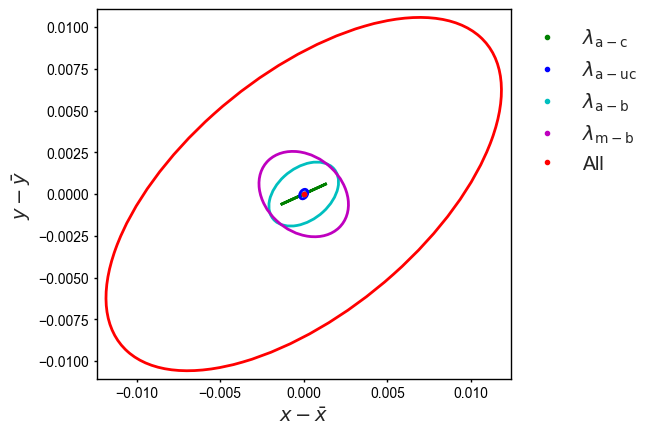

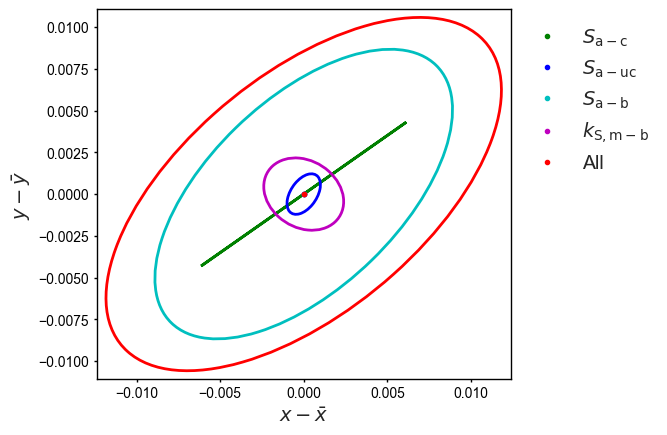

In [15]:
ax = None
len_part1 = 5
index_end = input_len

for i in [*range(1, len_part1), index_end]:
    var = mcResult[i]
    if i == index_end:
        ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[0], ax1=ax, name=get_name(i), number=0, grid=False)
    else:
        ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i], ax1=ax, name=get_name(i), number=0, grid=False)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left",frameon=False,fontsize=label_font_size)
save_fig(out_dir, 'xy_lambda_all')

ax = None
for i in range(len_part1, input_len+1):
    var = mcResult[i]
    if i == index_end:
        ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[0], ax1=ax, name=get_name(i), number=0, grid=False)
    else:
        ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i-len_part1+1], ax1=ax, name=get_name(i), number=0, grid=False)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False,fontsize=label_font_size)
save_fig(out_dir, 'xy_S_all')

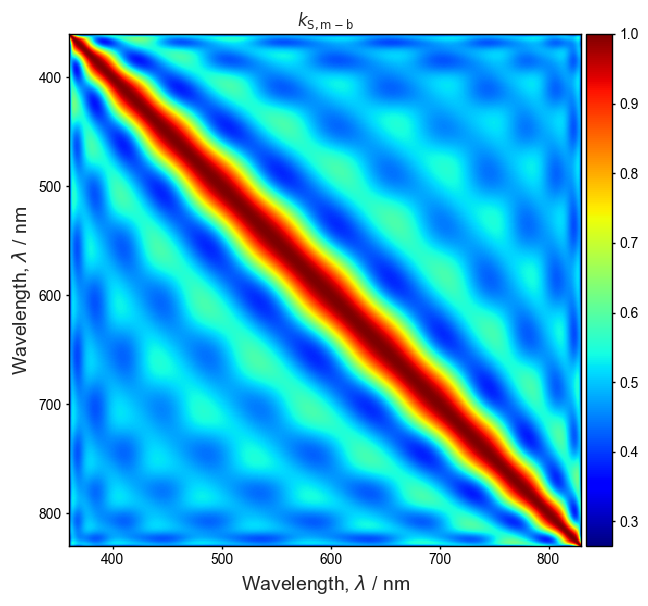

In [16]:
def corrDiag(mcResult_loc, diag_number, desc_offset):
    var = mcResult_loc[diag_number]
    var[-1].calc_cov_matrix_from_data()
    plotCorrelation(var[-1].runData.corr_matrix, wl, get_name(diag_number), x_label=x_label, y_label=x_label)
    save_fig(out_dir, 'DataCorr_' + str(desc_offset) + '_' + str(diag_number))

for i in range(input_len+1):
    if i == 8:
        corrDiag(mcResult, i, 0)

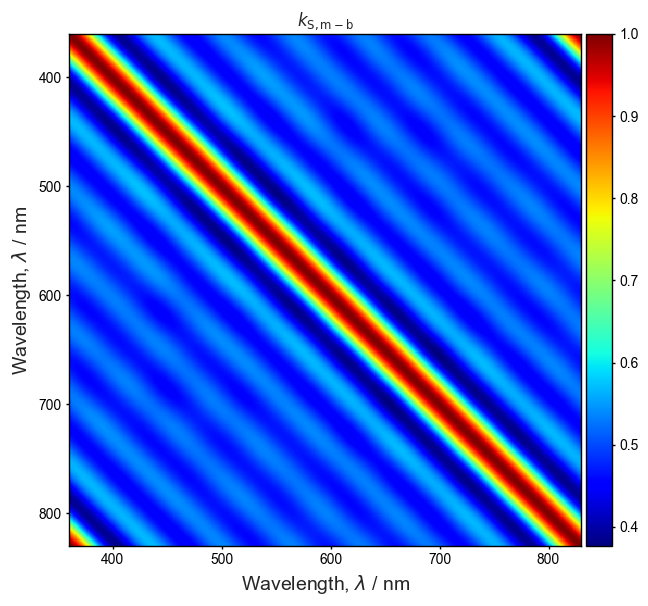

In [17]:
input1 = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f1]
output1 = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
mcResult1, res_data1 = runSimpleMC(input1, output1, NumberTrials, model_L0)
corrDiag(mcResult1, 8, 1)

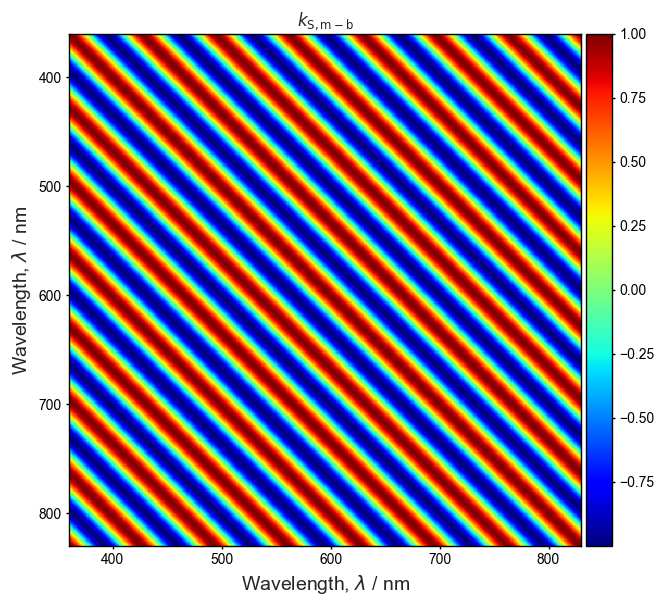

In [18]:
input2 = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f2]
output2 = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
mcResult2, res_data2 = runSimpleMC(input2, output2, NumberTrials, model_L0)
corrDiag(mcResult2, 8, 2)

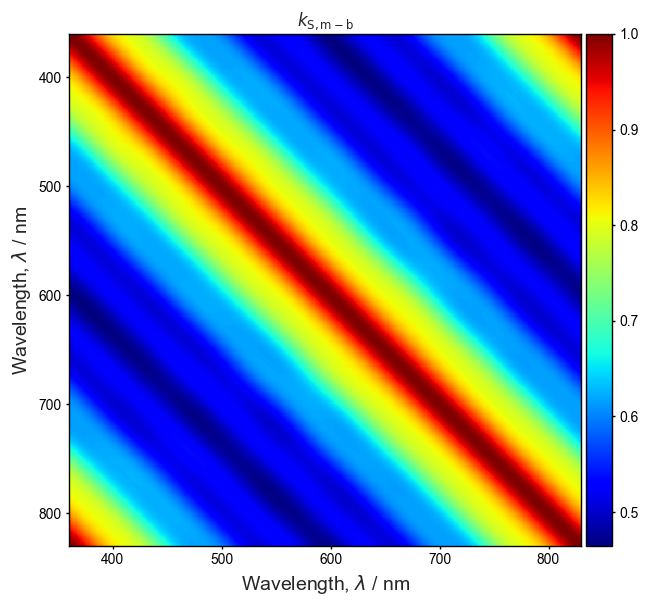

In [19]:
input3 = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f3]
output3 = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
mcResult3, res_data3 = runSimpleMC(input3, output3, NumberTrials, model_L0)
corrDiag(mcResult3, 8, 3)

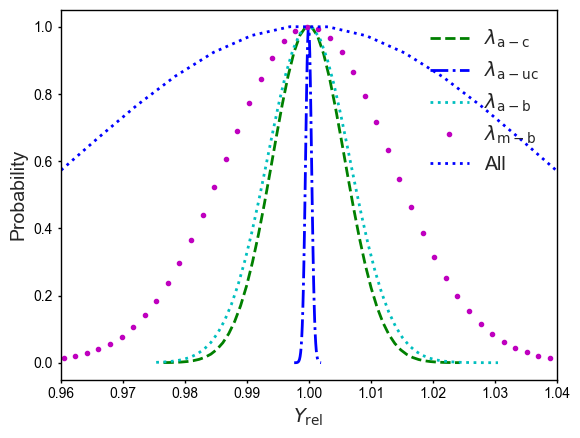

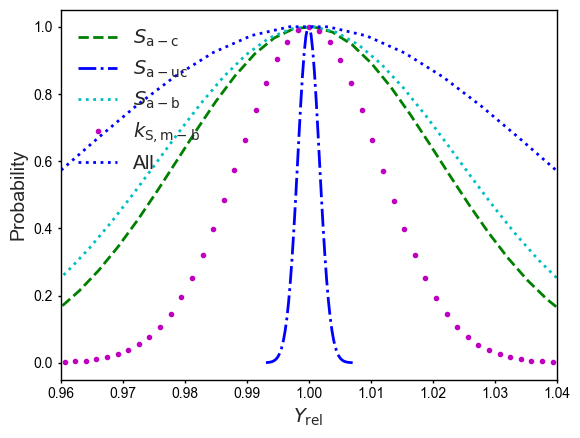

In [20]:
#display some histograms
ax1 = None
for i in [*range(1, len_part1), index_end]:
    var = mcResult[i]
    if ax1 is None:
        ax1 = plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', color=mColor[i]+marker[i], relative=True, fontsize=label_font_size)
    else:
        plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', ax=ax1, color=mColor[i]+marker[i], relative=True, fontsize=label_font_size)
pyplot.xlim([0.96,1.04])
pyplot.title('')
save_fig(out_dir, 'HistYxy_Yrel_Lambda')

ax1 = None
for i in range(len_part1, index_end+1):
    var = mcResult[i]
    if i == index_end:
        ii = i
    else:
        ii = i -len_part1+1
    if ax1 is None:
        ax1 = plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', color=mColor[ii]+marker[ii], relative=True, fontsize=label_font_size)
    else:
        plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', ax=ax1, color=mColor[ii]+marker[ii], relative=True, fontsize=label_font_size)
pyplot.xlim([0.96,1.04])
pyplot.title('')
save_fig(out_dir, 'HistYxy_Yrel_S')


Value= [1.0, 0.0026793082426234105] Inteval(95%)= 0.010475269033434875 U= 0.005237634516717438


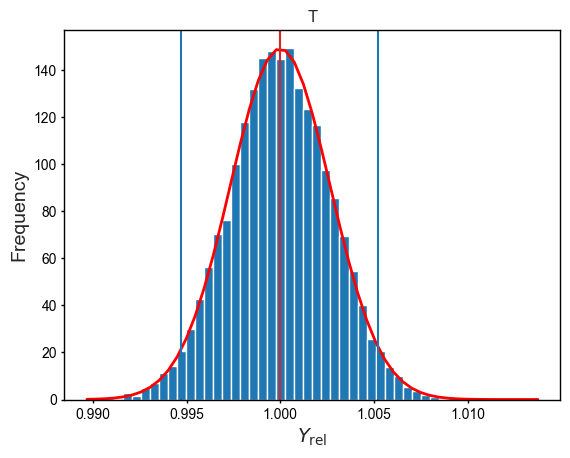

Value= [1.0, 0.0058153917015073405] Inteval(95%)= 0.022655024070903917 U= 0.011327512035451959


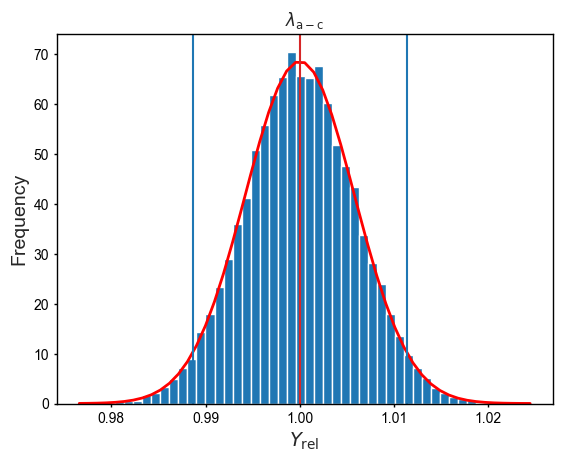

Value= [1.0, 0.00048293324502418606] Inteval(95%)= 0.0018979963746625916 U= 0.0009489981873312958


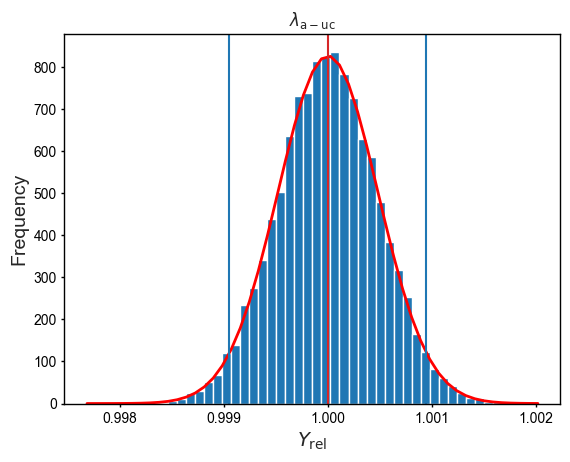

Value= [1.0, 0.006647514598867359] Inteval(95%)= 0.025658445814875197 U= 0.012829222907437599


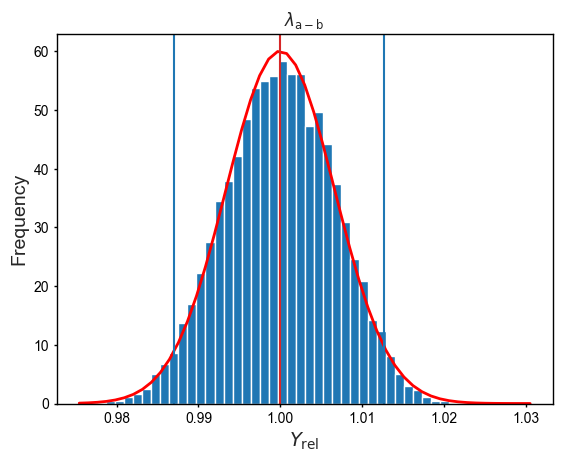

Value= [1.0, 0.013349702008291511] Inteval(95%)= 0.051647729853278035 U= 0.025823864926639017


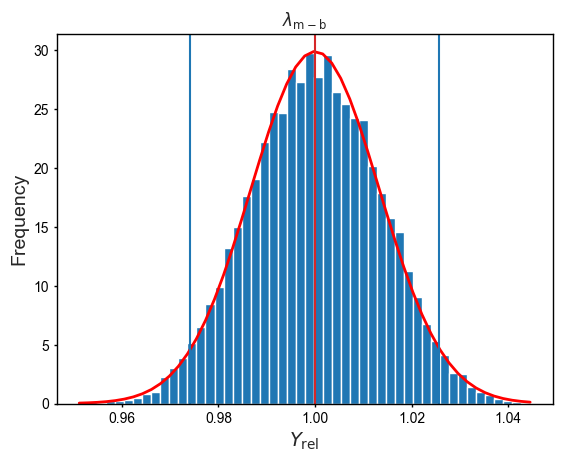

Value= [1.0000000000000002, 0.021057277307229973] Inteval(95%)= 0.08256156444728091 U= 0.041280782223640455


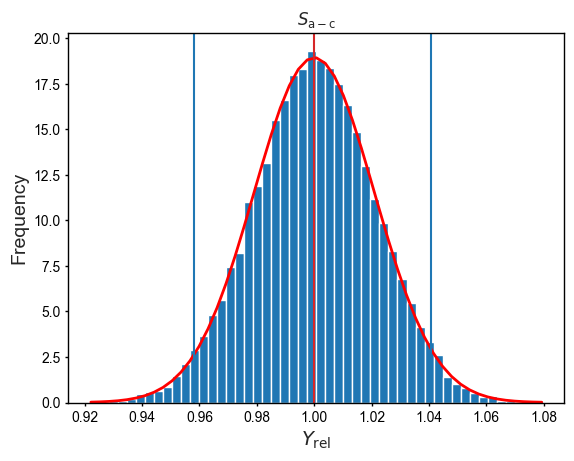

Value= [0.9999999999999998, 0.0017402101070417622] Inteval(95%)= 0.006860757728544775 U= 0.0034303788642723876


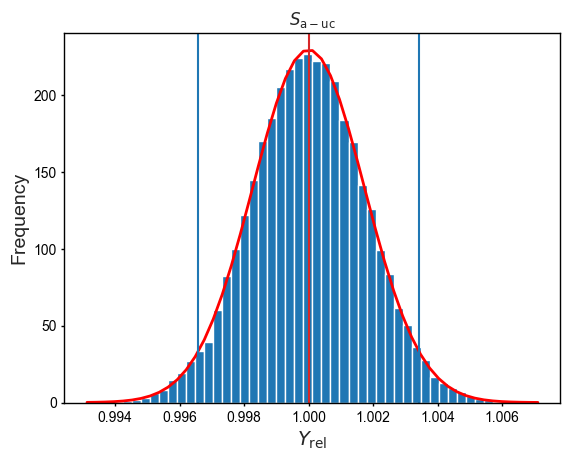

Value= [1.0000000000000002, 0.024090713155630102] Inteval(95%)= 0.09330484213540968 U= 0.04665242106770484


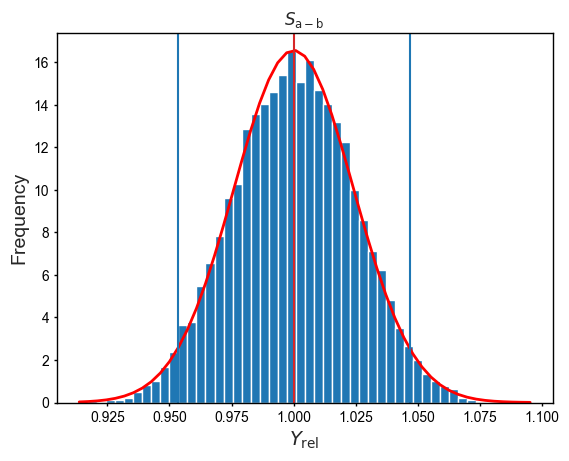

Value= [1.0000000000000002, 0.011339269763541967] Inteval(95%)= 0.04371163762708441 U= 0.021855818813542205


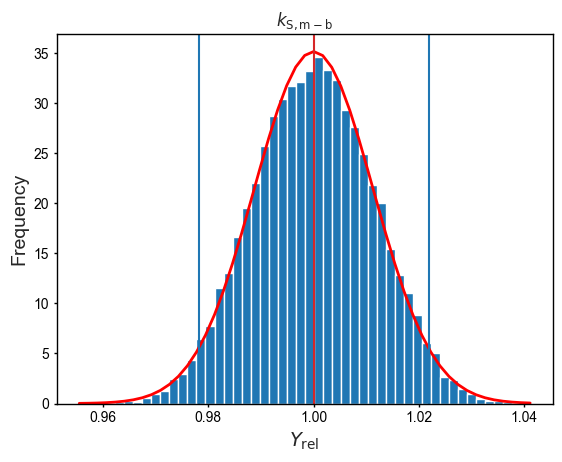

Value= [1.0000000000000002, 0.03771089813285373] Inteval(95%)= 0.14791032953964023 U= 0.07395516476982011


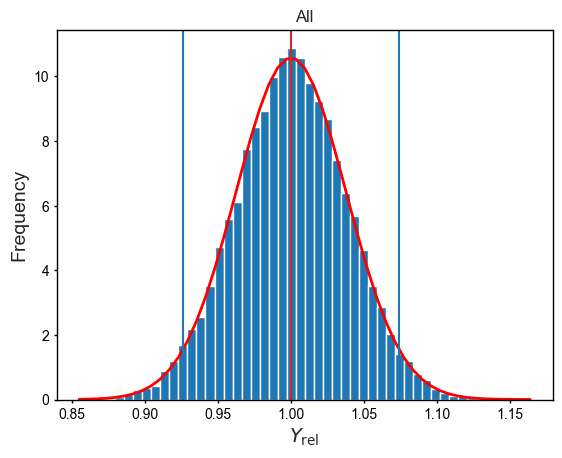

In [21]:
#display some histograms
for i in range(input_len+1):
    var = mcResult[i]
    plotHistScales( var[0].val[:,0]/np.mean(var[0].val[:,0]), add_distribution=True, title=get_name(i), xLabel='$Y_{\mathrm{rel}}$', fontsize=label_font_size, density=True)
    pyplot.ylabel('Frequency', fontsize=label_font_size)
    save_fig(out_dir, 'HistYxy_Lrel_'+str(i))

In [22]:
var = mcResult[0]
column_str_MC= [var[0].name.get_name_unit(0)[0], var[0].name.get_name_unit(1)[0], var[0].name.get_name_unit(2)[0],
                var[1].name.get_name_unit()[0], var[2].name.get_name_unit()[0]]
for i in range(input_len+1):
    var = mcResult[i]
    cct = mcResult[i][1]
    smcf = mcResult[i][2]
    print('Input_Var:', get_name(i))
    norm_data = pd.concat([pd.DataFrame(var[0].val[:,0]/np.mean(var[0].val[:,0])), pd.DataFrame(var[0].val[:,1]), pd.DataFrame(var[0].val[:,2]), pd.DataFrame(cct.val), pd.DataFrame(smcf.val)], axis=1)
    norm_data.columns = column_str_MC
    print( norm_data.corr())

Input_Var: T
              L           x           y         CCT           F
L    1.00000000 -0.99999840 -0.99999936  0.99999895  0.99999811
x   -0.99999840  1.00000000  0.99999978 -0.99999994 -0.99999999
y   -0.99999936  0.99999978  1.00000000 -0.99999995 -0.99999967
CCT  0.99999895 -0.99999994 -0.99999995  1.00000000  0.99999988
F    0.99999811 -0.99999999 -0.99999967  0.99999988  1.00000000
Input_Var: $\lambda_\mathrm{a-c}$
              L           x           y         CCT           F
L    1.00000000 -0.99999502 -0.99999948  0.99999997  0.99999312
x   -0.99999502  1.00000000  0.99999130 -0.99999579 -0.99999985
y   -0.99999948  0.99999130  1.00000000 -0.99999919 -0.99998884
CCT  0.99999997 -0.99999579 -0.99999919  1.00000000  0.99999404
F    0.99999312 -0.99999985 -0.99998884  0.99999404  1.00000000
Input_Var: $\lambda_\mathrm{a-uc}$
              L           x           y         CCT           F
L    1.00000000 -0.12590588  0.45782081  0.38037452  0.28698053
x   -0.12590588  1.000

Input_Var: T
Input_Var: $\lambda_\mathrm{a-c}$
Input_Var: $\lambda_\mathrm{a-uc}$
Input_Var: $\lambda_\mathrm{a-b}$
Input_Var: $\lambda_\mathrm{m-b}$
Input_Var: $S_\mathrm{a-c}$
Input_Var: $S_\mathrm{a-uc}$
Input_Var: $S_\mathrm{a-b}$
Input_Var: $k_\mathrm{S,m-b}$
Input_Var: All


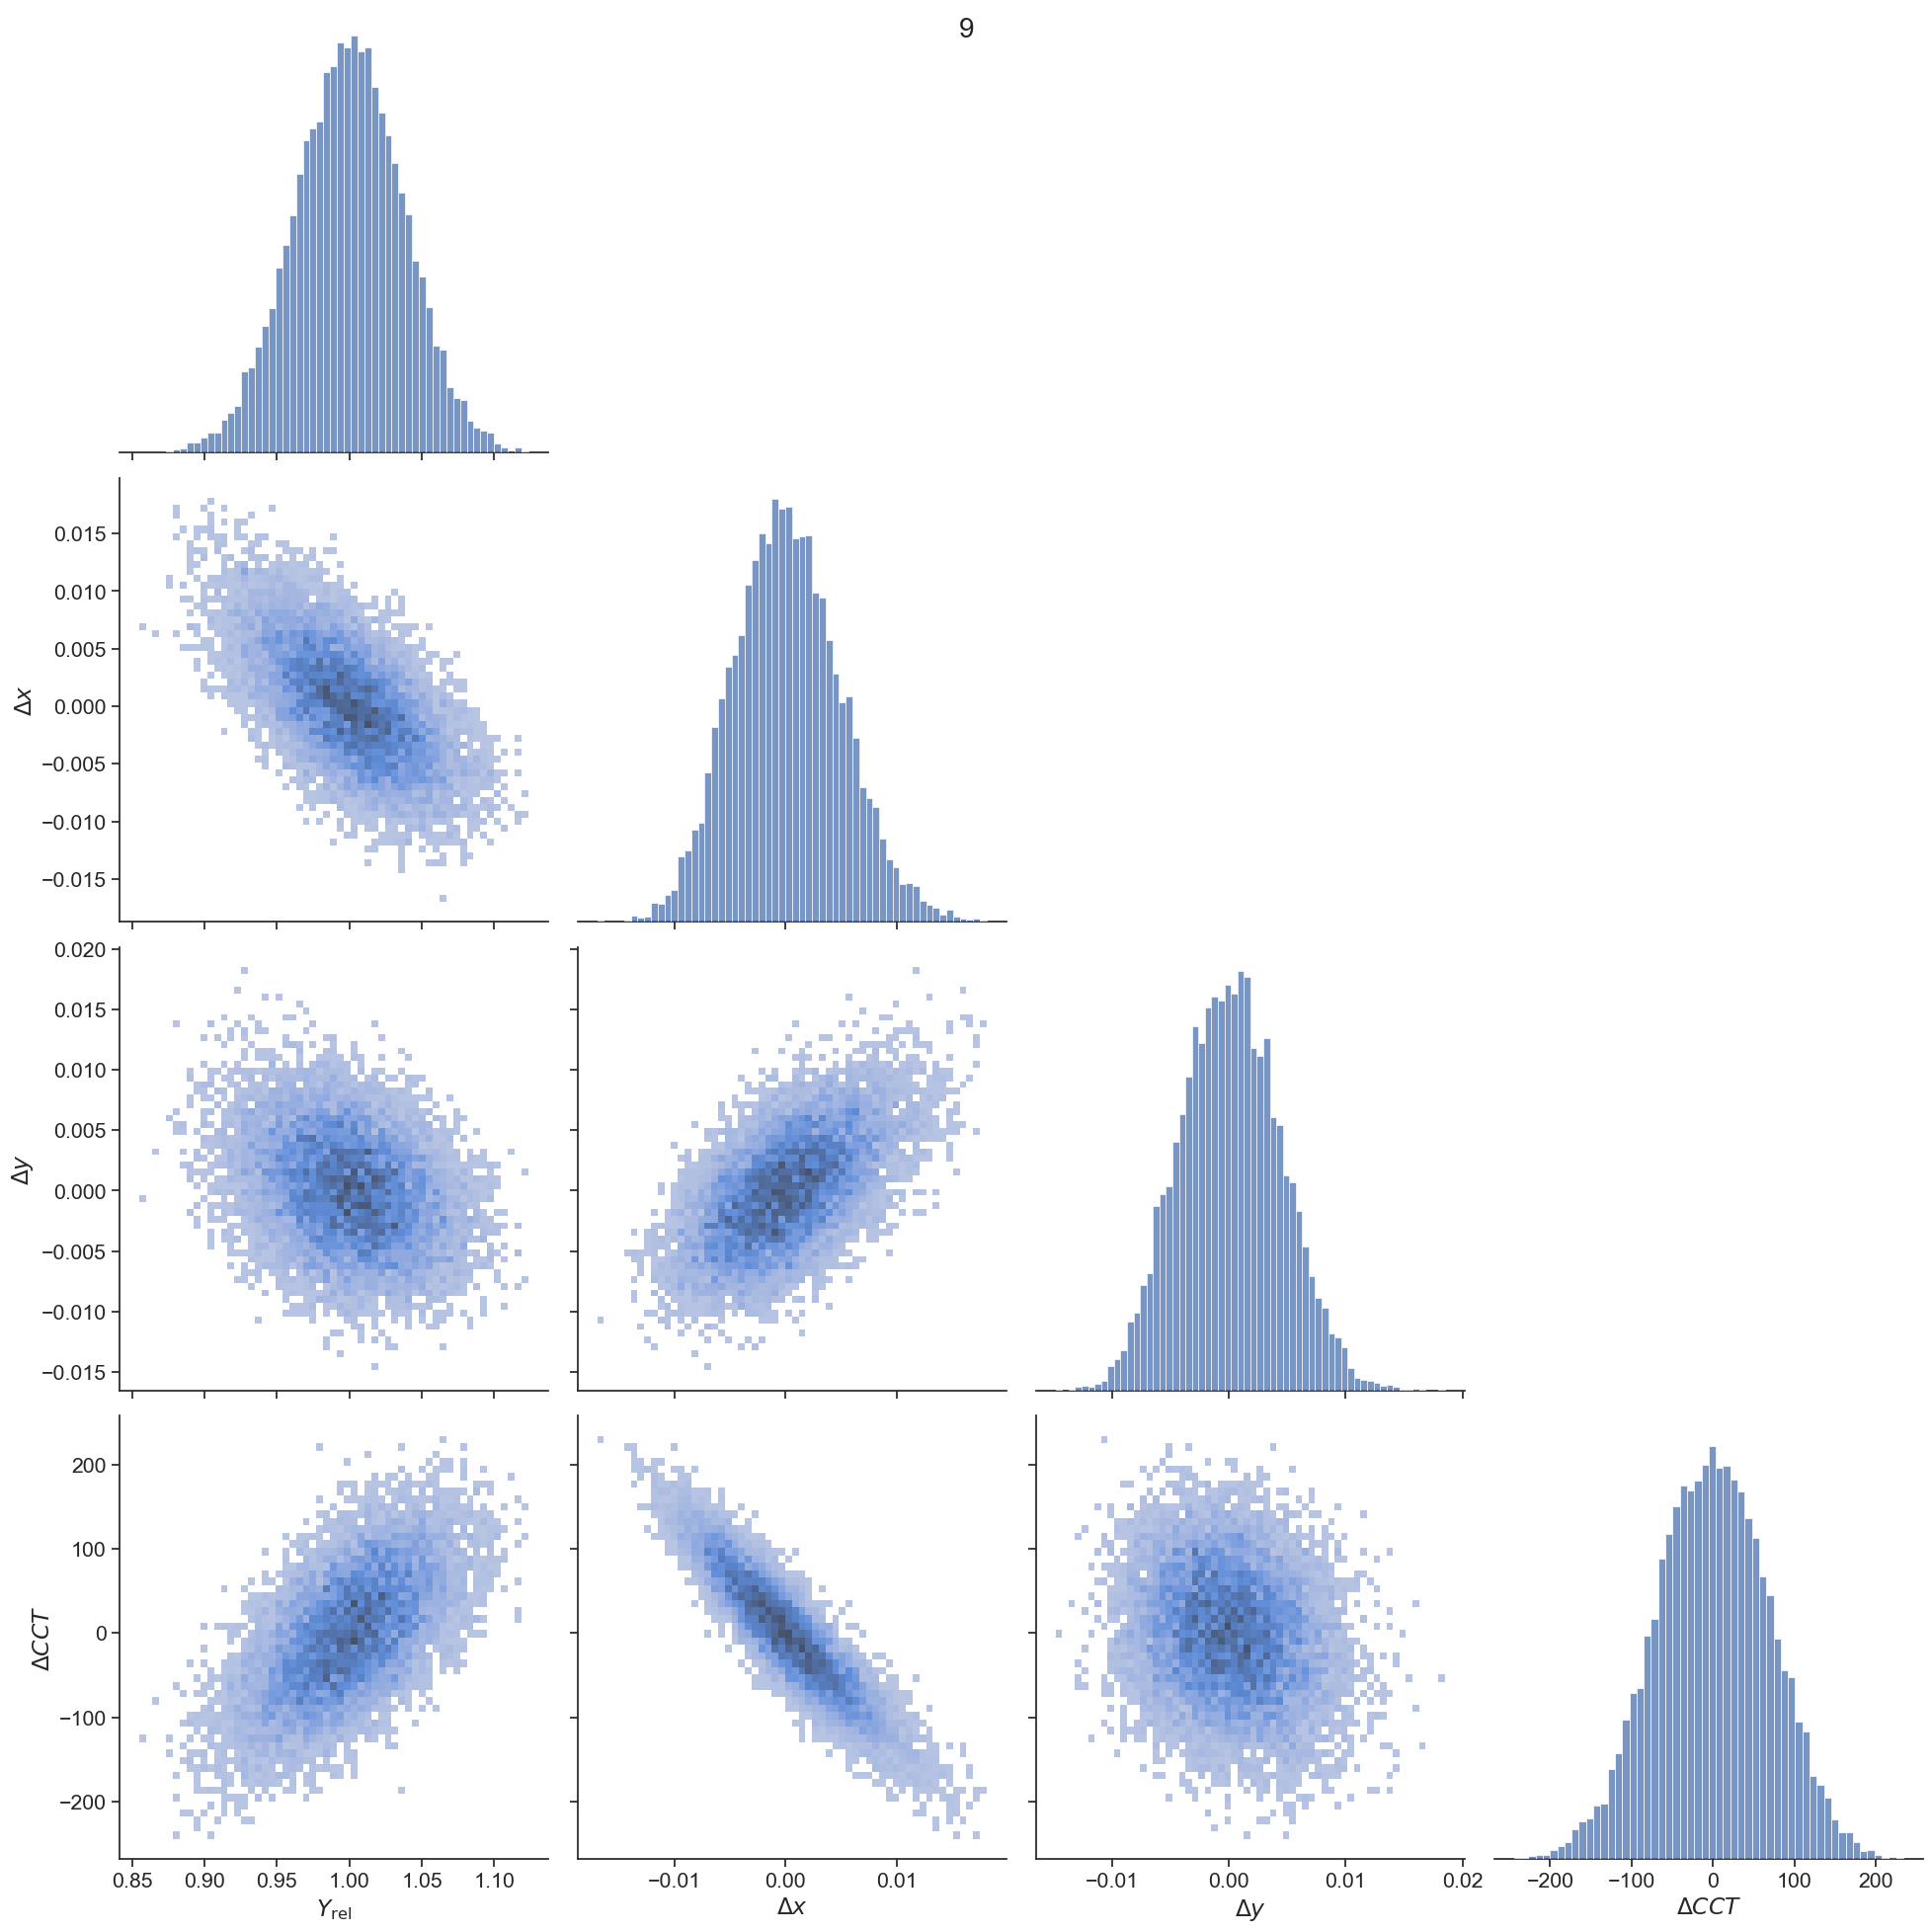

In [23]:
column_str_MC2= ['Y', var[0].name.get_name_unit(1)[0], var[0].name.get_name_unit(2)[0],
                var[1].name.get_name_unit()[0], var[2].name.get_name_unit()[0]]
# Stil wieder aktivieren
pyplot.style.use(plot_style)

for i in range(input_len+1):
    var = mcResult[i]
    cct = mcResult[i][1]
    smcf = mcResult[i][2]
    print('Input_Var:', get_name(i))
    if i==9:
        #seaborn_plot_result_gen(np.vstack((var[0].val.T, cct.val.T, smcf.val.T)), display=['r','d','d','d','n'], dim=5, column_str=column_str_MC2, title=str(i))
        seaborn_plot_result_gen(np.vstack((var[0].val.T, cct.val.T)), display=['r','d','d','d'], dim=4, column_str=column_str_MC2[0:4], title=str(i), fontsize=label_font_size,
                                kind='hist')
        save_fig(out_dir, 'Observation_YxyCCTDuv_' + str(i))

# Stil wieder aktivieren
pyplot.style.use(plot_style)

# Ende part 1

# Evaluattion the influence of the basefunctions

In [24]:
# run the MCS for different base function settings

mcResultList = []
str_observe = 'CCT'
index_observe = 0
observed_value = []
observed_uvalue = []
#mcResult, res_data = runSimpleMC(mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f, mcYxy, mcCCT, mcSMCF, mcSpectrum, NumberTrials, model_L0)
mcResult_db_merge = None
# base funcktion fourier and chebychev
output = [mcYxy, mcCCT, mcSMCF, mcSpectrum]
for base_function in ['f', 'c']:
    # sum of all functions or a single base function only
    for single_funktion in [' ', 's', '1f']:
        # use a list of base funkction numbrs
        for index, petriNumber in enumerate(elements2Run):
            addParamString = base_function + ' ' + str(petriNumber) + ' ' + single_funktion + ' o'
            print ( f'BaseFunkction: {base_function}, Single: {single_funktion}, Simulation number : {index}, PetriNumber: {petriNumber}, String: {addParamString}')
            if petriNumber == -1:
                # use the original calibration data (FEL, Photoelement from PTB)
                mcResult, mcResult_db = runSimpleMC( inputFEL, output, NumberTrials, model_FEL)
                index_observe = 0
            else:
                # the basic versions of FEL and Photometer do not use the correlation information (only value and standard deviation)
                mcS_m_f_t = MCVectorVar(name=NameUnit('$k_\mathrm{S,m-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean=1, stddev=0.01, add_params=addParamString)})
                mcS_m_f_t.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))
                input = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f_t]
                mcResult, mcResult_db = runSimpleMC( input, output, NumberTrials, model_L0)
                index_observe = 8

            print ( f"{str_observe}: {mcResult_db[str_observe].iloc[index_observe]:.8f} | u({str_observe}): {mcResult_db['u('+str_observe + ')'].iloc[index_observe]:.8f}")
            mcResultList.append(mcResult)

            mcResult_db = mcResult_db.assign(TRIALS=NumberTrials)
            mcResult_db = mcResult_db.assign(BASE=base_function)
            mcResult_db = mcResult_db.assign(E2R=petriNumber)
            mcResult_db = mcResult_db.assign(SINGLE=single_funktion)

            temp_cols=mcResult_db.columns.tolist()
            new_cols=temp_cols[-4:] + temp_cols[:-4]
            mcResult_db = mcResult_db[new_cols]

            if mcResult_db_merge is None:
                mcResult_db_merge = mcResult_db.copy()
            else:
                mcResult_db_merge = pd.concat([mcResult_db_merge, mcResult_db])

BaseFunkction: f, Single:  , Simulation number : 0, PetriNumber: -1, String: f -1   o
CCT: 3075.34102730 | u(CCT): 2.91995096
BaseFunkction: f, Single:  , Simulation number : 1, PetriNumber: 0, String: f 0   o
CCT: 3077.00000000 | u(CCT): 0.00000000
BaseFunkction: f, Single:  , Simulation number : 2, PetriNumber: 1, String: f 1   o
CCT: 3076.87439768 | u(CCT): 16.69249493
BaseFunkction: f, Single:  , Simulation number : 3, PetriNumber: 2, String: f 2   o
CCT: 3077.26189789 | u(CCT): 21.32993648
BaseFunkction: f, Single:  , Simulation number : 4, PetriNumber: 3, String: f 3   o
CCT: 3076.89873189 | u(CCT): 21.39745661
BaseFunkction: f, Single:  , Simulation number : 5, PetriNumber: 4, String: f 4   o
CCT: 3076.87303127 | u(CCT): 19.97772171
BaseFunkction: f, Single:  , Simulation number : 6, PetriNumber: 5, String: f 5   o
CCT: 3077.07488231 | u(CCT): 18.54561022
BaseFunkction: f, Single:  , Simulation number : 7, PetriNumber: 6, String: f 6   o
CCT: 3076.89088744 | u(CCT): 17.11957144


In [25]:
mcResult_db_merge

,TRIALS,BASE,E2R,SINGLE,Input,Unit,Mean,StdDev,Distr,L,u(L),x,u(x),y,u(y),CCT,u(CCT),F,u(F)
0,20000,f,-1,,Input#0,Unit#0,0.05002378,0.00022769,normal,0.99998262,0.00457597,0.43182880,0.00015911,0.40254011,0.00009539,"3,075.34102730",2.91995096,1.00242230,0.00001853
0,20000,f,-1,,All,,0.00000000,0.00000000,,0.99998262,0.00457597,0.43182880,0.00015911,0.40254011,0.00009539,"3,075.34102730",2.91995096,1.00242230,0.00001853
0,20000,f,0,,T,K,"3,077.00000000",1.00000000,normal,0.99997470,0.00267837,0.43155562,0.00006857,0.40215567,0.00002540,"3,076.98953371",0.99978523,1.00240343,0.00001000
0,20000,f,0,,$\lambda_\mathrm{a-c}$,nm,0.00000000,1.00000000,normal,1.00004997,0.00579447,0.43155131,0.00056065,0.40215302,0.00025535,"3,077.06569829",7.78218686,1.00240398,0.00007449
0,20000,f,0,,$\lambda_\mathrm{a-uc}$,nm,0.00000000,1.00000000,normal,1.00000310,0.00048234,0.43155235,0.00009983,0.40215435,0.00011725,"3,077.03647464",1.74142202,1.00240368,0.00002332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,20000,c,235,1f,$S_\mathrm{a-c}$,,0.00000000,0.01000000,normal,0.99998775,0.02128216,0.43162127,0.00253023,0.40220195,0.00177372,"3,076.63816473",29.94123709,1.00239751,0.00027938
0,20000,c,235,1f,$S_\mathrm{a-uc}$,,0.00000000,0.01000000,normal,1.00000485,0.00174932,0.43155343,0.00041159,0.40215665,0.00049762,"3,077.04424571",6.42925500,1.00240359,0.00008852
0,20000,c,235,1f,$S_\mathrm{a-b}$,,0.00000000,0.01000000,normal c 7,0.99982065,0.02406501,0.43161488,0.00361216,0.40217583,0.00353355,"3,076.86525337",52.12334056,1.00239241,0.00041650
0,20000,c,235,1f,"$k_\mathrm{S,m-b}$",,1.00000000,0.01000000,normal c 235 1f o,1.00000113,0.00119849,0.43155506,0.00017942,0.40215503,0.00016244,"3,076.99575741",3.68308805,1.00240346,0.00004718


In [26]:
strDataBase = out_dir + '/database.csv'
strDataBase_k = out_dir + '/database_k.csv'

mcResult_db_merge.to_csv(strDataBase, index=False, sep=';', decimal='.', float_format='%.5f', mode='w')
mcResult_db_merge.to_csv(strDataBase_k, index=False, sep=';', decimal=',', float_format='%.5f', mode='w')

In [27]:
use_short = 1
# Run the very first and second cell and start with use_short = 1 here in the case you will skip the simulation
if use_short:
    strDataBase = out_dir + '/database.csv'
    mcResult_db_merge = pd.read_csv(strDataBase, sep=';', decimal='.')

L


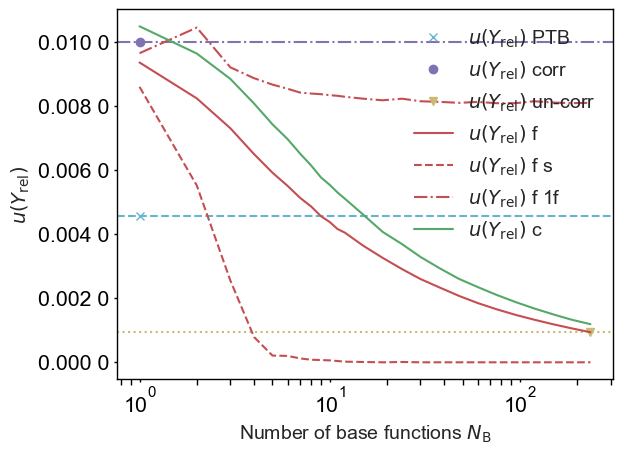

x


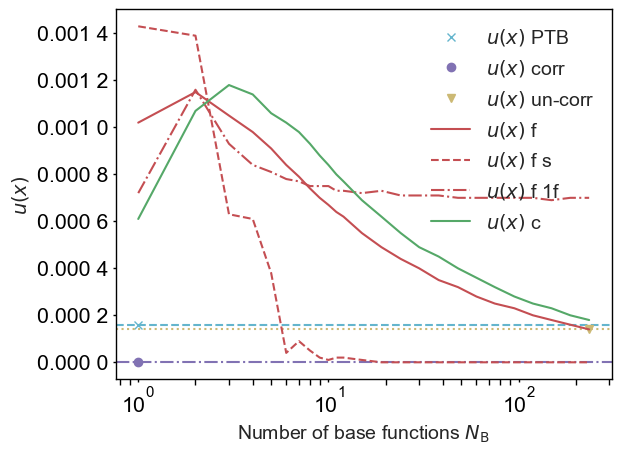

y


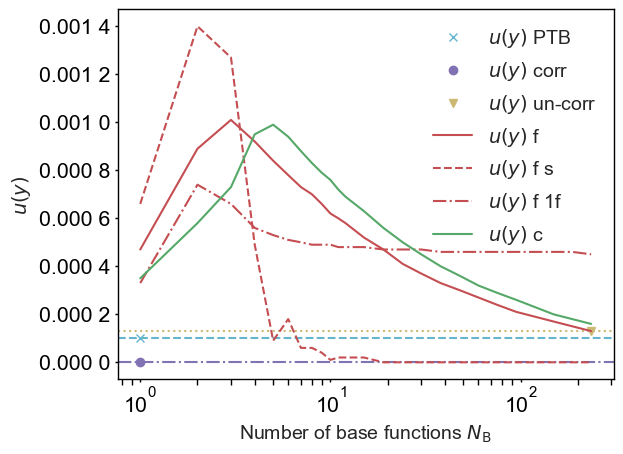

CCT


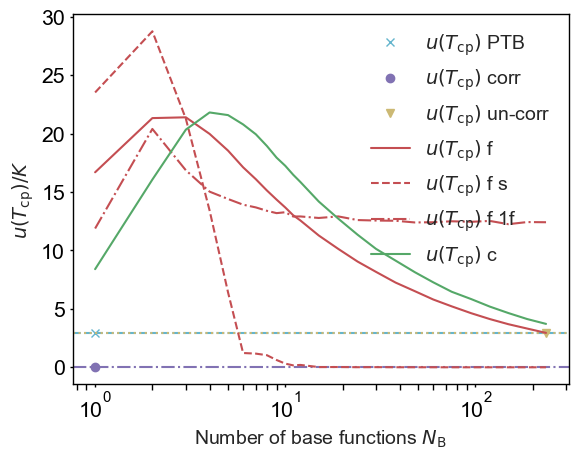

F


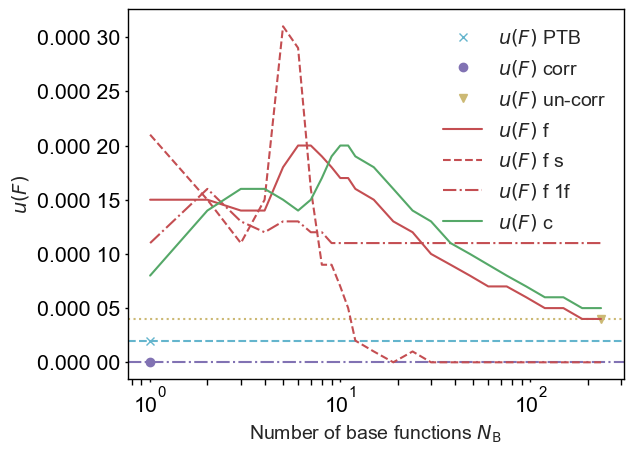

In [28]:
str_observe_list = ['L', 'x', 'y', 'CCT', 'F']
str_observe_unit = ['', '', '', 'K', '']
str_observe_listP = ['Y_\mathrm{rel}', 'x', 'y', 'T_{\mathrm{cp}}', 'F']

# to be moved to plotting ...
marker = ['-', '--', '-.',':']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

for str_observe in str_observe_list:
    list_index = str_observe_list.index(str_observe)
    str_observeP = str_observe_listP[list_index]
    fig, ax = pyplot.subplots()
    ii = 0
    for base_function in ['f', 'c']:
        iii=0
        for single_function in [' ', 's', '1f']:
            if base_function == 'c' and single_function != ' ':
                continue
            observed_value = []
            observed_uvalue = []
            dfq = []
            for index in range(len(elements2Run)):
                element = elements2Run[index]
                if element == -1:
                    dfq = mcResult_db_merge.query("Input=='Input#0'")
                    index_observe = 0
                else:
                    dfq = mcResult_db_merge.query("E2R==@element and BASE==@base_function and SINGLE==@single_function")
                    index_observe = 8
                observed_value.append(dfq[str_observe].iloc[index_observe])
                observed_uvalue.append(dfq['u(' + str_observe + ')'].iloc[index_observe])
            if ii==0 and iii==0:
                ax.plot(1, observed_uvalue[0], mColor[3]+point_marker[ii], label='$u(' + str_observeP + ')$' + ' PTB')
                ax.axhline(observed_uvalue[0], color = mColor[3], linestyle='--')
                ax.plot(1, observed_uvalue[1], mColor[4]+point_marker[ii+1], label='$u(' + str_observeP + ')$' + ' corr')
                ax.axhline(observed_uvalue[1], color = mColor[4], linestyle='-.')
                ax.plot(elements2Run[-1], observed_uvalue[-1], mColor[5]+point_marker[ii+2], label='$u(' + str_observeP + ')$' + ' un-corr')
                ax.axhline(observed_uvalue[-1], color = mColor[5], linestyle=':')

            ax.plot(elements2Run[2:], observed_uvalue[2:], mColor[ii]+marker[iii], label='$u(' + str_observeP + ')$' + ' ' + base_function + ' ' + single_function)
            iii+=1
        ii+=1
    ax.set_xscale('log')
    ax.set_xlabel(r"Number of base functions $N_\mathrm{B}$",fontsize=label_font_size)
    if str_observe == 'F':
        ax.set_ylabel('$u(' + str_observeP + ')$',fontsize=label_font_size)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color1))
    else:
        if len(str_observe_unit[list_index]):
            ax.set_ylabel('$u(' + str_observeP + ') / ' + str_observe_unit[list_index] +'$',fontsize=label_font_size)
        else:
            ax.set_ylabel('$u(' + str_observeP + ')$',fontsize=label_font_size)
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color))

    ax.legend(frameon=False,fontsize=label_font_size)
#    ax2 = ax.twiny()
#    new_tick_locations = range( len(elements2Run))
#    def tick_function(X):
#        return ["%d" % elements2Run[z] for z in X]
#    ax2.set_xlim((1,500))
#    ax2.set_xticks(new_tick_locations)
#    ax2.set_xticklabels(tick_function(new_tick_locations))
#    pyplot.tick_params(axis='both', labelrotation=90, labelsize=10)

#    ax2.set_xscale('log')
#    ax2.set_xticks(elements2Run[2::2])
#    ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

    print( str_observe)
    save_fig(out_dir, 'base' + str_observe)

In [29]:
# Ende part 2
break

SyntaxError: 'break' outside loop (2891655628.py, line 2)

# LED Test

In [ ]:
# run the MCS for different base function settings

mcResultList = []
str_observe = 'lpeak'
index_observe = 0
observed_value = []
observed_uvalue = []
#mcResult, res_data = runSimpleMC(mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f, mcYxy, mcCCT, mcSMCF, mcSpectrum, NumberTrials, model_L0)
mcResult_db_merge = None
# base funcktion fourier and chebychev
for base_function in ['f', 'c']:
    # sum of all functions or a single base function only
    for single_funktion in [' ', 's']:
        # use a list of base funkction numbrs
        for index, petriNumber in enumerate(elements2Run):
            addParamString = base_function + ' ' + str(petriNumber) + ' ' + single_funktion + ' o'
            print ( f'BaseFunkction: {base_function}, Single: {single_funktion}, Simulation number : {index}, PetriNumber: {petriNumber}, String: {addParamString}')
            output = [mcYxy, mclpeak, mcSMCF, mcSpectrum]
            if petriNumber == -1:
                inputLED = [mcLED, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f]
                mcResult, mcResult_db = runSimpleMC(inputLED, output, NumberTrials, model_LED)
                index_observe = 0
            else:
                # the basic versions of FEL and Photometer do not use the correlation information (only value and standard deviation)
                mcS_m_f_t = MCVectorVar(name=NameUnit('$k_\mathrm{S,m-b}$', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean=1, stddev=0.01, add_params=addParamString)})
                mcS_m_f_t.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))
                inputLED = [mcLED, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_f, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_f_t]
                mcResult, mcResult_db = runSimpleMC(inputLED, output, NumberTrials, model_LED)
                index_observe = 8

            print ( f"{str_observe}: {mcResult_db[str_observe].iloc[index_observe]:.8f} | u({str_observe}): {mcResult_db['u('+str_observe + ')'].iloc[index_observe]:.8f}")
            mcResultList.append(mcResult)

            mcResult_db = mcResult_db.assign(TRIALS=NumberTrials)
            mcResult_db = mcResult_db.assign(BASE=base_function)
            mcResult_db = mcResult_db.assign(E2R=petriNumber)
            mcResult_db = mcResult_db.assign(SINGLE=single_funktion)

            temp_cols=mcResult_db.columns.tolist()
            new_cols=temp_cols[-4:] + temp_cols[:-4]
            mcResult_db = mcResult_db[new_cols]

            if mcResult_db_merge is None:
                mcResult_db_merge = mcResult_db.copy()
            else:
                mcResult_db_merge = pd.concat([mcResult_db_merge, mcResult_db])

In [ ]:
mcResult_db_merge

In [ ]:
str_observe_list = ['L', 'x', 'y', 'lpeak', 'F']
str_observe_unit = ['', '', '', 'nm', '']
str_observe_listP = ['Y_\mathrm{rel}', 'x', 'y', '\lambda_{\mathrm{peak}}', 'F']

# to be moved to plotting ...
marker = ['-', '--', '-.',':']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

for str_observe in str_observe_list:
    list_index = str_observe_list.index(str_observe)
    str_observeP = str_observe_listP[list_index]
    fig, ax = pyplot.subplots()
    ii = 0
    for base_function in ['f', 'c']:
        iii=0
        for single_function in [' ', 's']:
            observed_value = []
            observed_uvalue = []
            dfq = []
            for index in range(len(elements2Run)):
                element = elements2Run[index]
                if element == -1:
                    dfq = mcResult_db_merge.query("E2R==@element")
                    index_observe = 0
                else:
                    dfq = mcResult_db_merge.query("E2R==@element and BASE==@base_function and SINGLE==@single_function")
                    index_observe = 8
                observed_value.append(dfq[str_observe].iloc[index_observe])
                observed_uvalue.append(dfq['u(' + str_observe + ')'].iloc[index_observe])
            if ii==0 and iii==0:
                #ax.plot(1, observed_uvalue[0], mColor[3]+point_marker[ii], label='$u(' + str_observeP + ')$' + ' PTB')
                #ax.axhline(observed_uvalue[0], color = mColor[3], linestyle='--')
                ax.plot(1, observed_uvalue[1], mColor[4]+point_marker[ii+1], label='$u(' + str_observeP + ')$' + ' corr')
                ax.axhline(observed_uvalue[1], color = mColor[4], linestyle='-.')
                ax.plot(elements2Run[-1], observed_uvalue[-1], mColor[5]+point_marker[ii+2], label='$u(' + str_observeP + ')$' + ' un-corr')
                ax.axhline(observed_uvalue[-1], color = mColor[5], linestyle=':')

            ax.plot(elements2Run[2:], observed_uvalue[2:], mColor[ii]+marker[iii], label='$u(' + str_observeP + ')$' + ' ' + base_function + ' ' + single_function)
            iii+=1
        ii+=1
    ax.set_xscale('log')
    ax.set_xlabel(r"Number of base functions $N_\mathrm{B}$",fontsize=label_font_size)
    if str_observe == 'F':
        ax.set_ylabel('$u(' + str_observeP + ')$',fontsize=label_font_size)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color1))
    else:
        if len(str_observe_unit[list_index]):
            ax.set_ylabel('$u(' + str_observeP + ') / ' + str_observe_unit[list_index] +'$',fontsize=label_font_size)
        else:
            ax.set_ylabel('$u(' + str_observeP + ')$',fontsize=label_font_size)
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_color))

    ax.legend(frameon=False,fontsize=label_font_size)
#    ax2 = ax.twiny()
#    new_tick_locations = range( len(elements2Run))
#    def tick_function(X):
#        return ["%d" % elements2Run[z] for z in X]
#    ax2.set_xlim((1,500))
#    ax2.set_xticks(new_tick_locations)
#    ax2.set_xticklabels(tick_function(new_tick_locations))
#    pyplot.tick_params(axis='both', labelrotation=90, labelsize=10)

#    ax2.set_xscale('log')
#    ax2.set_xticks(elements2Run[2::2])
#    ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

    print( str_observe)
    save_fig(out_dir, 'LEDbase' + str_observe)

In [ ]:
# Ende Gelände